# ****Import Libraries & Read Data****

In [1]:
import bz2
from tqdm import tqdm
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix,classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SpatialDropout1D,Embedding
from keras.callbacks import ModelCheckpoint

In [2]:
output_path='/kaggle/working/train.ft.txt'
with bz2.open('/kaggle/input/amazonreviews/train.ft.txt.bz2', 'rt', encoding='utf-8') as compressed_file, open(output_path, 'w', encoding='utf-8') as output_file:
    for line in compressed_file:
        output_file.write(line)
    print('Train Successful ❤')
output_path='/kaggle/working/test.ft.txt'
with bz2.open('/kaggle/input/amazonreviews/test.ft.txt.bz2', 'rt', encoding='utf-8') as compressed_file, open(output_path, 'w', encoding='utf-8') as output_file:
    for line in compressed_file:
        output_file.write(line)
    print('Test Successful ❤')

Train Successful ❤
Test Successful ❤


In [2]:
train,test,train_label,test_label=[],[],[],[]
with open('train.ft.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
for line in tqdm(lines):
    train.append(line.split('__label__')[1][1:])
    train_label.append(line.split('__label__')[1][0])
with open('test.ft.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
for line in tqdm(lines):
    test.append(line.split('__label__')[1][1:])
    test_label.append(line.split('__label__')[1][0])

100%|██████████| 400000/400000 [00:00<00:00, 721642.28it/s]


In [3]:
def clean_text(text):
    # Remove non-alphanumeric characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert multiple whitespace characters to a single space
    text = re.sub(r'\s+', ' ', text)
    # Convert the text to lowercase
    text = text.lower()
    return text

In [7]:
print('Train Length',len(train))
print('Train Label Length',len(train_label))
print('Test Length',len(test))
print('Test Label Length',len(test_label))

Train Length 3600000
Train Label Length 3600000
Test Length 400000
Test Label Length 400000


In [6]:
train_label[0],train[0]

('2',
 ' Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n')

In [7]:
train_label[0],clean_text(train[0])

('2',
 ' stuning even for the nongamer this sound track was beautiful it paints the senery in your mind so well i would recomend it even to people who hate vid game music i have played the game chrono cross but out of all of the games i have ever played it has the best music it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras it would impress anyone who cares to listen ')

In [8]:
test_label[0],test[0]

('2',
 ' Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"\n')

In [9]:
test_label[0],clean_text(test[0])

('2',
 ' great cd my lovely pat has one of the great voices of her generation i have listened to this cd for years and i still love it when im in a good mood it makes me feel better a bad mood just evaporates like sugar in the rain this cd just oozes life vocals are jusat stuunning and lyrics just kill one of lifes hidden gems this is a desert isle cd in my book why she never made it big is just beyond me everytime i play this no matter black white young old male female everybody says one thing who was that singing ')

In [10]:
#train label
pd.DataFrame(train_label).value_counts()

1    1800000
2    1800000
dtype: int64

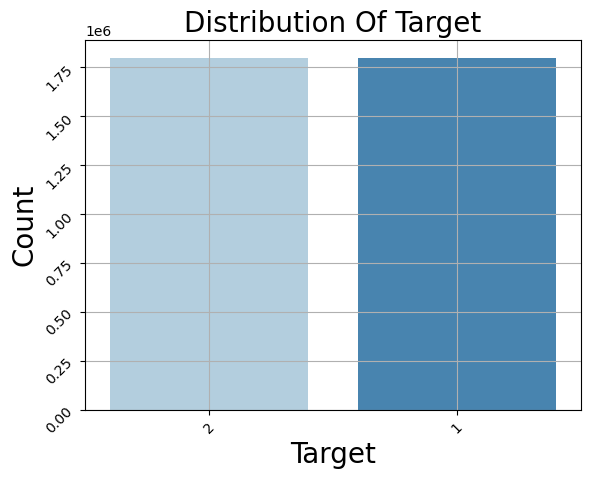

In [11]:
sns.countplot(x=pd.DataFrame(train_label)[0],palette='Blues')
plt.title('Distribution Of Target',fontsize=20)
plt.xlabel('Target',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [12]:
#test label
pd.DataFrame(test_label).value_counts()

1    200000
2    200000
dtype: int64

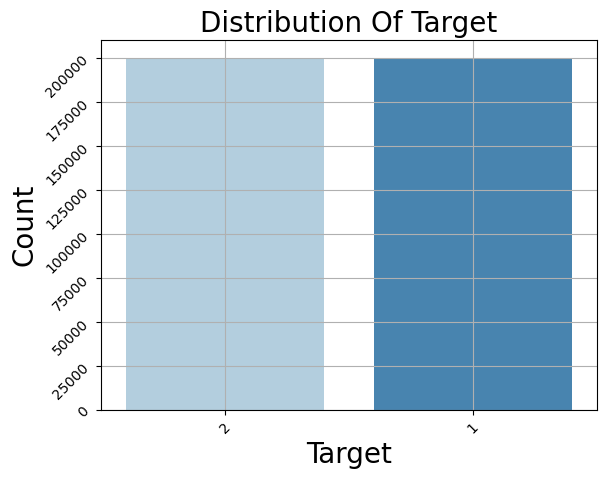

In [13]:
sns.countplot(x=pd.DataFrame(test_label)[0],palette='Blues')
plt.title('Distribution Of Target',fontsize=20)
plt.xlabel('Target',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [4]:
train=pd.DataFrame(train)[0].apply(clean_text)
test=pd.DataFrame(test)[0].apply(clean_text)
train.head()

0     stuning even for the nongamer this sound trac...
1     the best soundtrack ever to anything im readi...
2     amazing this soundtrack is my favorite music ...
3     excellent soundtrack i truly like this soundt...
4     remember pull your jaw off the floor after he...
Name: 0, dtype: object

In [9]:
test.head()

0     great cd my lovely pat has one of the great v...
1     one of the best game music soundtracks for a ...
2     batteries died within a year i bought this ch...
3     works fine but maha energy is better check ou...
4     great for the nonaudiophile reviewed quite a ...
Name: 0, dtype: object

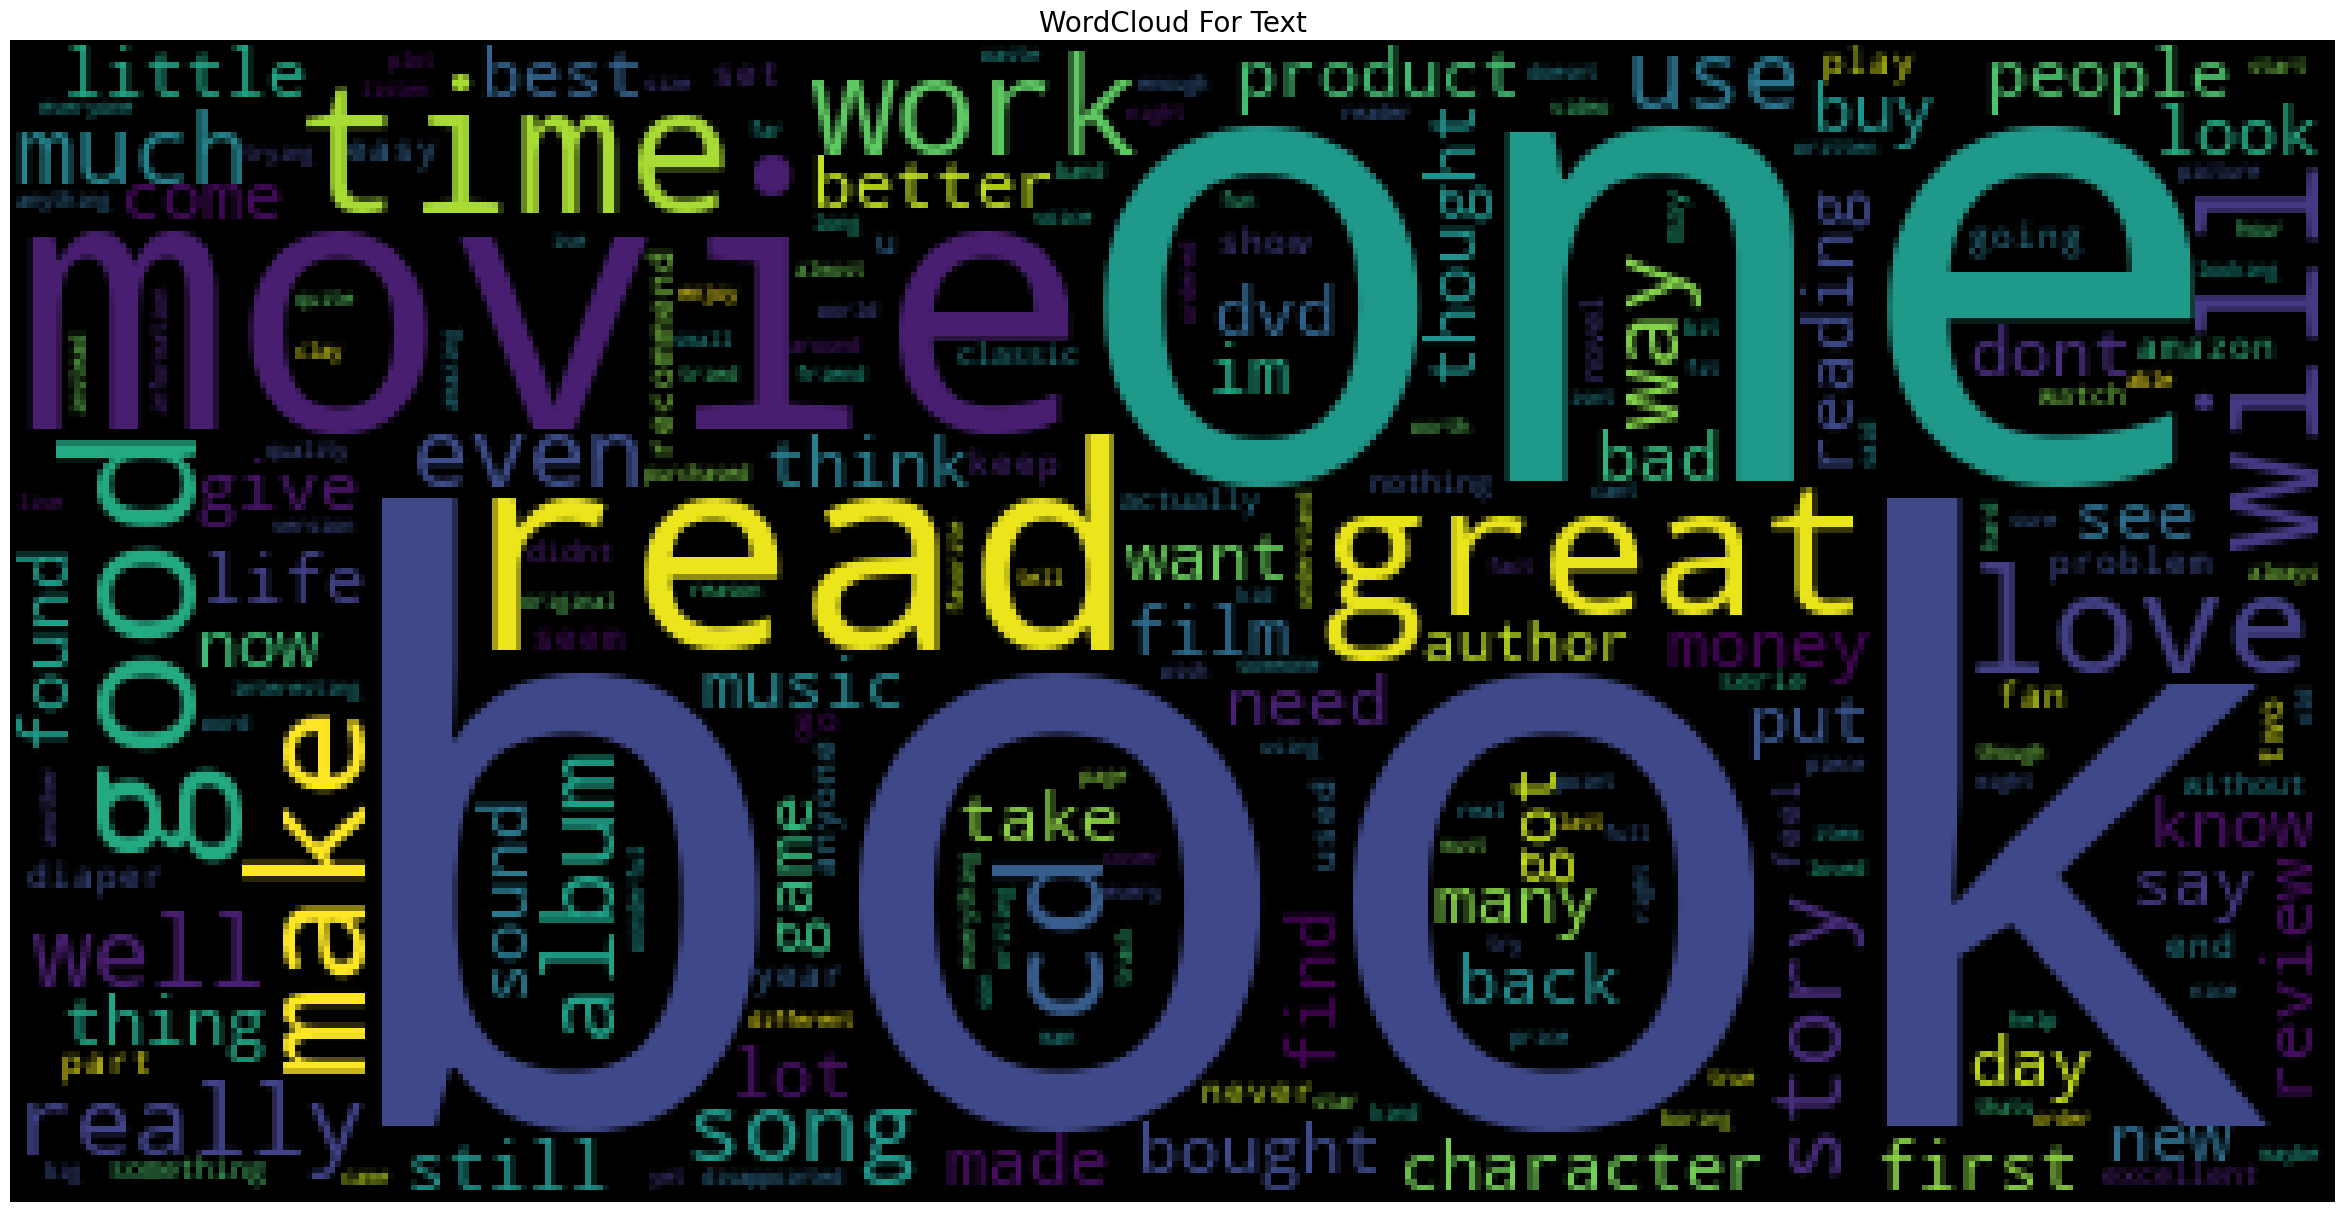

In [5]:
plt.figure(figsize=(30,20))
plt.imshow(WordCloud().generate(" ".join(train.iloc[:20000])))
plt.axis("off")
plt.title("WordCloud For Text",fontsize=20)
plt.show()

In [10]:
voc_size = 20000
max_length = 100
tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(train)
word_index = tokenizer.word_index

In [11]:
train = tokenizer.texts_to_sequences(train)
train = pad_sequences(train, maxlen=max_length)
test = tokenizer.texts_to_sequences(test)
test = pad_sequences(test, maxlen=max_length)

In [12]:
train_lab=np.array([1 if i=='2' else 0 for i in train_label])
test_lab=np.array([1 if i=='2' else 0 for i in test_label])

# **Model Bulding**

In [13]:
model = Sequential()
model.add(Embedding(input_dim=voc_size, output_dim=64, input_length=max_length))
model.add(LSTM(units=32, return_sequences=True))
model.add(SpatialDropout1D(rate=0.2))  
model.add(LSTM(units=32))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           1280000   
                                                                 
 lstm (LSTM)                 (None, 100, 32)           12416     
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,300,769
Trainable params: 1,300,769
Non-trainable params: 0
______________________________________________

In [15]:
checkpoint_cb =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(train, train_lab, epochs=2,
                    validation_split=.1,
                    callbacks=[checkpoint_cb])

Epoch 1/2
101250/101250 [==============================] - 1263s 12ms/step - loss: 0.1732 - accuracy: 0.9335 - val_loss: 0.1520 - val_accuracy: 0.9432
Epoch 2/2
101250/101250 [==============================] - 1222s 12ms/step - loss: 0.1449 - accuracy: 0.9459 - val_loss: 0.1452 - val_accuracy: 0.9455


In [17]:
loss,accuracy = model.evaluate(test, test_lab)
print("Loss:", loss)
print("Accuracy:", accuracy)

12500/12500 [==============================] - 70s 6ms/step - loss: 0.1480 - accuracy: 0.9442
Loss: 0.14796611666679382
Accuracy: 0.9442124962806702


In [18]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.173166,0.933462,0.152021,0.943214
1,0.144854,0.945896,0.145158,0.945469


In [19]:
prediction=model.predict(test)
y_pred=np.where(prediction>=.5,1,0)
df=pd.DataFrame()
df['actual'],df['pred']=test_lab,y_pred

12500/12500 [==============================] - 62s 5ms/step


In [21]:
df

,actual,pred
0,1,1
1,1,1
2,0,0
3,1,0
4,1,1
...,...,...
399995,0,0
399996,0,0
399997,0,0
399998,1,1


# ****Model Check****

array([[189382,  10618],
       [ 11697, 188303]])

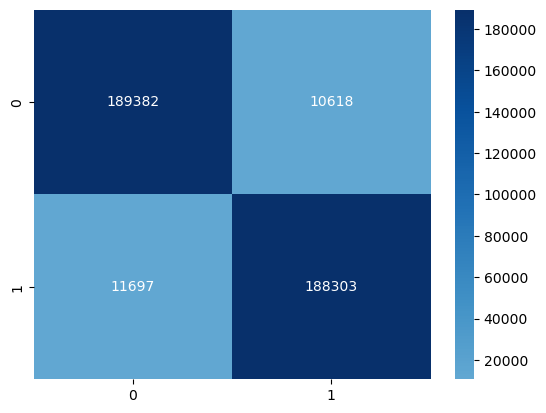

In [24]:
CM = confusion_matrix(test_lab, y_pred)
sns.heatmap(CM,annot=True,center = True,fmt='g',cmap='Blues')
CM

In [26]:
ClassificationReport = classification_report(test_lab,y_pred)
print('Classification Report is : ', ClassificationReport) 

Classification Report is :                precision    recall  f1-score   support

           0       0.94      0.95      0.94    200000
           1       0.95      0.94      0.94    200000

    accuracy                           0.94    400000
   macro avg       0.94      0.94      0.94    400000
weighted avg       0.94      0.94      0.94    400000

